<a href="https://colab.research.google.com/github/MatiasSepulvedaGodoy/myocardial-perfusion-segmentation/blob/develop/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-processing images**

This colab is an example for load, processing and apply ROI detection in the images.

We load libraries that we don't have in colab:

In [ ]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 5.2 MB/s 


We import libraries:

In [ ]:
import os
import pydicom
import numpy as np
import torch
import torchvision
import nibabel as nib
from google.colab.patches import cv2_imshow

## Load images with Pytorch


We create a pytorch Dataset class for load all the images:

In [ ]:
class MyocardialPerfusionDataset(torch.utils.data.Dataset):

    def __init__(self, root, transform=True) -> None:
        self.root = root
        self.transform = transform

        # create a dictionary for images.
        locations = list(sorted(os.listdir(os.path.join(self.root, 'dicom'))))
        img_dict = []
        for loc in locations:
            marks_ = nib.load(os.path.join(self.root, 'marks', '%s.nii.gz' % loc)).get_fdata()
            for index, img in enumerate(list(sorted(os.listdir(os.path.join(self.root, loc))))):
                if np.max(marks_[:,:,index]) > 0:
                    dict_ = {'patient_id': loc, 'img_dir': os.path.join(self.root, loc, img), 'mark': index}
                    img_dict.append(dict_)
        
        self.img_dict = img_dict

    def __getitem__(self, idx):
        path_img = self.img_dict[idx]['img_dir']
        
        # We load raw image from dicom.
        dicom = pydicom.read_file(path_img).pixel_array
        dicom = dicom.astype('int32')

        # We load mark for the image.
        mark = nib.load(os.path.join(self.root, 'marks', '%s.nii.gz' % self.img_dict[idx]['patient_id'])).get_fdata()[self.img_dict[idx]['mark']]

## Create Dataloader

## Utils

In [ ]:
path = '/content/drive/MyDrive/Tesis/images/P-UCH/dicom/5371-2/IM-0002-0037-0001.dcm'

In [ ]:
img = pydicom.read_file(path).pixel_array
img = img.astype('int32')

In [ ]:
class ToTensor(object):

    def __call__(self, sample):

        image = torch.from_numpy(sample)
        image = torch.unsqueeze(image, dim=0)
        return image

class ClipNorm(object):

    def __init__(self, lower=0, upper=99):
      self.lower = lower
      self.upper = upper
    

    def __call__(self, sample):

      lower_clip, upper_clip = np.percentile(sample, (self.lower, self.upper))
      clip_sample = sample.clip(min=lower_clip, max=upper_clip)
      clip_sample = self.rescale_intensity(clip_sample, (0, 255))

      return clip_sample

    def rescale_intensity(self, tensor, out_range):

      current_min = torch.min(tensor)
      current_max = torch.max(tensor)

      tensor = (tensor - current_min) / (current_max - current_min)
      tensor = out_range[0] + tensor * (out_range[1] - out_range[0])

      return tensor

class ZeroPad(object):

    def __init__(self, size=256):
      self.size = size

    def __call__(self, sample):
      if max(sample.size()[1], sample.size()[2]) > self.size:
        raise ValueError("Data can't be padded to a smaller shape.")
      
      h_pad = self.size - sample.size()[1]
      w_pad = self.size - sample.size()[2]

      padding_left = h_pad // 2
      padding_right = h_pad - padding_left

      padding_top = w_pad // 2
      padding_bottom = w_pad - padding_top
 
      padding = (padding_left, padding_right, padding_top, padding_bottom)

      paddet_data = torch.nn.functional.pad(sample, padding)

      return paddet_data          

In [ ]:
composed = torchvision.transforms.Compose([ToTensor(), ClipNorm(), ZeroPad()])

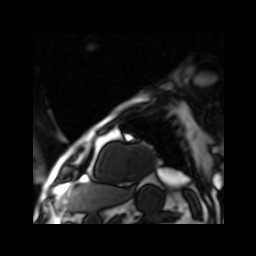

In [ ]:
cv2_imshow(np.asarray(composed(img).permute(1, 2, 0)))